In [ ]:
#-*- coding: utf-8 -*-
"""
File: option2.ipynb
Author: Eddie Kelly
Date: 2024

This file is part of the Quantum algorithm for linear systems of equations for the multi-dimensional Black-Scholes equations project which was completed as part 
of the thesis https://mural.maynoothuniversity.ie/id/eprint/19288/.

License: MIT License
"""

import os 
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))) # For importing from parent directory

import numpy as np

import itertools
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit 
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import *
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import UnitaryGate

from HHL.hhl import hhl, HHL_Solver, hhl_poly_pauli_rot
from HHL.ancillacircuit import eigenvalueextract_range
from Matrices.matrixmod import hermitify_matrix
from BlackScholes.bs_differential_op import black_scholes_1D_prop, black_scholes_1D_improp, black_scholes_1D_analytic
from BlackScholes.lognormal import normal_1D_stock



np.set_printoptions(linewidth=1000,suppress=True,precision=3)

<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x7f5b7d2bb290> at 0x7f5b2ab12c00>

# This is the classical matrix equation to be solved: #

$$
     \mathbf{M}\vec{\tilde{X}} = \vec{\tilde{V}}
$$

$$
\begin{gather}
     \underbrace{
     \begin{pmatrix}
          I & 0& 0& 0\\
          -A\Delta t & I & 0 & 0 \\
          0& -\frac{A\Delta t}{2}& I& 0 \\
          -I & -I& -I & I\\
     \end{pmatrix}
     }_{\mathbf{M}}
     \underbrace{
     \begin{pmatrix}
          \vec{x}_{1} \\ 
          \vec{x}_{2} \\ 
          \vec{x}_{3} \\ 
          \vec{x}_{4} \\ 
     \end{pmatrix}
     }_{\vec{\tilde{X}}}
     =
     \underbrace{
     \begin{pmatrix}
          \vec{V}_{0} \\
          \Delta t \vec{V}_{1} \\
          \vec{0} \\
          \vec{0} \\
     \end{pmatrix}
     }_{\vec{\tilde{V}}}
\end{gather}          
$$

The matrices $A,I$ will each have dimension 8 ($A , I \in \operatorname{GL}_{8}$). The matrix $A$ will correspond to the
Black-Scholes differential operator with 8 spatial discretization points. Hence each vector $\{\vec{x}_{i}\}_{i=1,2,3,4} \in \mathbb{C}^{8}$.  The value of the option at a time increment $\Delta t$ later will be encoded in each of the amplitudes for the $\vec{x}_{4}$ vector $\textbf{only}$. Due to the hermiticty, we will solve a slightly adapted problem.

$$
     \text{Price of option encoded on grid prices at  }  \Delta t \text{  will be  } \approx \vec{x}_{4}
$$

# The actual matrix problem we will solve is : #
$$
\begin{gather}
     \begin{pmatrix}
          0 & \mathbf{M} \\
          \mathbf{M}^{\dagger} & 0 \\
     \end{pmatrix}
     \begin{pmatrix}
          \vec{0} \\
          \vec{\tilde{X}} \\
     \end{pmatrix}
     =
     \begin{pmatrix}
          \vec{\tilde{V}} \\
          \vec{0} \\
     \end{pmatrix}
\end{gather}
$$

$$
\begin{gather}
     \begin{pmatrix}
          0 & 0 & 0 & 0 & I & 0 & 0 & 0 \\
          0 & 0 & 0 & 0 & -A\Delta t & I & 0 & 0\\
          0 & 0 & 0 & 0 & 0 &  -\frac{A\Delta t}{2}& I & 0\\
          0 & 0 & 0 & 0 & -I & -I & -I & I \\
          I & -A^{\dagger}\Delta t & 0 & -I & 0 & 0 & 0 & 0 \\
          0 & I & -\frac{A^{\dagger}\Delta t}{2} & -I & 0 & 0 & 0 & 0 \\
          0 & 0 & I & -I & 0 & 0 & 0 & 0 \\
          0 & 0 & 0 & I & 0 & 0 & 0 & 0 \\
     \end{pmatrix}
     \begin{pmatrix}
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{x}_{1} \\
          \vec{x}_{2} \\
          \vec{x}_{3} \\
          \vec{x}_{4} \\
     \end{pmatrix}
     =
     \begin{pmatrix}
          \vec{V}_{0} \\
          \Delta t\vec{V}_{1} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
     \end{pmatrix}
\end{gather}
$$
If we have succesful post-selection, we should have the quantum state:
$$
\begin{gather}
     \ket{\Psi} = \frac{1}{\sqrt{\sum_{i=1}^{4}||\vec{x}_{i}||^{2}}}
     \begin{pmatrix}
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{x}_{1} \\
          \vec{x}_{2} \\
          \vec{x}_{3} \\
          \vec{x}_{4} \\
     \end{pmatrix}
\end{gather}
$$

We can estimate the price of the option by $\operatorname{SWAP}$ test with the solution and another quantum state $\ket{P}$ whose amplitudes encode the probability distribution of stock price movement. 

$$
\begin{gather}
     \ket{P} = \frac{1}{||\vec{p}||}
     \begin{pmatrix}
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{0} \\
          \vec{p} \\
     \end{pmatrix}
\end{gather}
$$

Then we get that from their overlap, which is calculated from $|\langle ..|.. \rangle| = \sqrt{1-2\operatorname{Prob}(\ket{1}_{SWAP-qubit})}$: 
$$
     |\langle P \ket{\Psi}| = \frac{1}{||\vec{p}||\sqrt{\sum_{i=1}^{4}||\vec{x}_{i}||^{2}}}|\vec{p} \cdot \vec{x}_{4}|
$$


As the price of the option is (where $\Delta x$ is grid stepsize ) :
$$
\operatorname{OptionPrice}(2\Delta t) \approx e^{-r2\Delta t}|\vec{p} \cdot \vec{x}_{4}|\Delta x 
$$
We get the quantum estimated price as:
$$
\operatorname{OptionPrice}(2\Delta t) \approx e^{-r2\Delta t}\left(||\vec{p}||\sqrt{\sum_{i=1}^{4}||\vec{x}_{i}||^{2}}\right)\left(\sqrt{1-2\operatorname{Prob}(\ket{1}_{SWAP-qubit})}\right)
$$
We can estimate the normalisation of the solution from :
$$
     \sqrt{\sum_{i=1}^{4}||\vec{x}_{i}||^{2}} = \frac{||\vec{\tilde{V}}||}{\text{Chosen ancilla normalisation 'C'}}\sqrt{\operatorname{Prob}(\ket{1}_{ANCILLA-qubit})}
$$

In [ ]:
#---Define the parameters relating to Black-Scholes model---#
S_0 = 30
K = 55
vol = 0.45
r = 0.05
T_0 = 0.25
T_1 = 0.25
Total_life_option = T_0 + T_1

#---Define the parameters relating to the discretization---#
n_grid = 16
x_lower= 0
x_upper= 6
spatial_step = (x_upper-x_lower)/(n_grid + 1)          # Due to fact we are excluding the boundary points from simulation
Num_block = 1
Size_block = 3
temporal_step = T_0/Num_block                           # We only simulate the PDE up T_0


def convert_to_x(j):
    return ((x_upper-x_lower)/(n_grid+1))*(j+1) + x_lower # Assume zero indexing for regular vectors as well here

grid = [convert_to_x(i) for i in range(0,n_grid)]

#--Initial Condition--#

V_0_std =np.maximum(K - np.exp(grid),0)

#--Boundary Conditions--#

V_1_std = np.zeros(n_grid)
V_1_std[0] = (vol**2 -r)*K

#--Probability vector --#                   (I have not generated this yet)

prob_stock_price = []    
     
for i in grid:
    prob_stock_price.append(normal_1D_stock(i,np.log(S_0),r,vol,T_1)*spatial_step)   # Scaling by spatial step here.

prob_stock_price = np.array(prob_stock_price)
                                                                                     # Both of these steps are not necessary as vector will have to be normalized for state loading


print("\033[91m -- The grid below: --\033[0m")
print(grid)
print("\033[91m-- The exponentiated grid below: --\033[0m")
print(np.round(np.exp(grid),2))
print("\033[91m-- V_0 (before scaling) : -----------------------\033[0m")
print(V_0_std)
print("\033[91m-- V_1 :------------------------\033[0m")
print(V_1_std)
print("\033[91m-- P  & ||P|| : ----------------\033[0m")
print(f"{prob_stock_price}")
print(f"\033[93m{np.linalg.norm(prob_stock_price):.5f}\033[0m")



 -- The grid below: --
[0.35294117647058826, 0.7058823529411765, 1.0588235294117647, 1.411764705882353, 1.7647058823529413, 2.1176470588235294, 2.4705882352941178, 2.823529411764706, 3.1764705882352944, 3.5294117647058827, 3.882352941176471, 4.235294117647059, 4.588235294117648, 4.9411764705882355, 5.294117647058824, 5.647058823529412]
-- The exponentiated grid below: --
[  1.42   2.03   2.88   4.1    5.84   8.31  11.83  16.84  23.96  34.1   48.54  69.08  98.32 139.93 199.16 283.46]
-- V_0 (before scaling) : -----------------------
[53.577 52.974 52.117 50.897 49.16  46.688 43.171 38.164 31.038 20.896  6.462  0.     0.     0.     0.     0.   ]
-- V_1 :------------------------
[8.388 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
-- P  & ||P|| : ----------------
[0.    0.    0.    0.    0.    0.    0.    0.027 0.402 0.514 0.056 0.001 0.    0.    0.    0.   ]
0.65541


In [6]:
# --- Definition of the matrix A, M_tilde, and herm_M_tilde --- #

A = black_scholes_1D_prop(n_grid,spatial_step,r,vol) # Discretization operator for 8 grid points


# -- Construction of the M_tilde matrix -- #

M_tilde = np.kron(np.array([[1,0,0,0],
                            [0,1,0,0],
                            [0,0,1,0],
                            [0,0,0,1]]),np.eye(n_grid))         # This is the identities all along main diagonal

M_tilde = M_tilde + np.kron(np.array([[0,0,0,0],    # This is the negative identities at the bottom
                                     [0,0,0,0],
                                     [0,0,0,0],
                                     [-1,-1,-1,0]]),np.eye(n_grid)) 

M_tilde = M_tilde + np.kron(np.array([[0,0,0,0],    # This is the A matrix in the second row
                                     [-1,0,0,0],
                                     [0,0,0,0],
                                     [0,0,0,0]]),A*temporal_step)

M_tilde = M_tilde + np.kron(np.array([[0,0,0,0],    # This is the A matrix in the third row
                                     [0,0,0,0],
                                     [0,-1,0,0],
                                     [0,0,0,0]]),A*temporal_step*0.5)


# -- Construction of the herm_M_tilde matrix -- #

#           (0  M)
#           (M^t   0)

herm_M_tilde = np.kron(np.array([[0,0],[1,0]]),M_tilde.T) + np.kron(np.array([[0,1],[0,0]]),M_tilde) #THis is the format I am sticking with for now 


# -- Scaling the herm_M_tilde matrix -- #

scaling_factor = np.max(np.abs(np.linalg.eigvals(herm_M_tilde)))
herm_M_tilde_scaled = (1/scaling_factor)*herm_M_tilde

print("\033[91m--- M_tilde_matrix: ------------------------------------\033[0m")
print(M_tilde,M_tilde.shape[0])
print("\033[91m--- herm_M_tilde_matrix: -------------------------------\033[0m")
print(herm_M_tilde,herm_M_tilde.shape[0])
print("\033[91m--- The eigenvalues of the Herm-M-tilde matrix: --------\033[0m")
print(np.round(np.linalg.eigvals(herm_M_tilde),2))
print("\033[91m--- The |eigenvalues| of the herm_M_tilde matrix: ------\033[0m")
print(np.round(np.abs(np.linalg.eigvals(herm_M_tilde)),2))
print("\033[91m--- Largest |eigenvalue| and thus the scaling factor ---\033[0m")
print(np.round(scaling_factor,2))



--- M_tilde_matrix: ------------------------------------
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 64
--- herm_M_tilde_matrix: -------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 128
--- The eigenvalues of the Herm-M-tilde matrix: --------
[ 2.4   2.39  2.38  2.37  2.35 -2.4  -2.39 -2.38 -2.37 -2.35 -2.33  2.33  2.31 -2.31 -2.29  2.29  2.27  2.25 -2.27 -2.25 -2.24  2.24  2.22  2.21  2.19  2.19 -2.22 -2.21 -2.19 -2.19  2.2  -2.2   1.15  1.14 -1.15 -1.14 -1.13  1.13  1.12 -1.12 -1.1   1.1  -1.09  1.09 -1.07  1.07 -1.05  1.05  0.88  0.85  0.91  0.82 -0.91 -0.88 -0.85 -0.82 -0.94 -0.78  0.94  0.78 -0.75  0.75 -1.04  1.04 -0.73  0.73  0.97 -0.97  0.7  -0.7   1.03 -1.03  0.69 -0.69 -0.68  0.68  0.67 -0.67  0.67 -0.67  1.02 -1.02 -0.98  0.98  0.46

## Circuit construction ## 

In [7]:
#-----------------Parameters for HHL circuit size - first_vector register-----------------#

# ------ First vector that HHL will actually try to invert  ------ # 

first_vector = (np.kron(np.array([1,0,0,0,0,0,0,0]),V_0_std) + np.kron(np.array([0,1,0,0,0,0,0,0]),temporal_step*V_1_std))
first_vector_scaled = (1/scaling_factor)*first_vector


# ------ Second vector encoding the probability of stock price evolution ------ #

second_vector = prob_stock_price


#------------Matrix printing-----------------#
print("-- This is the first vector and its norm ----------------")
print(first_vector)
print(f"\033[95m{np.linalg.norm(first_vector):.3f}\033[0m")
print("\n")
print("This is the first vector scaled and its norm ------------")
print(first_vector_scaled)
print(f"\033[95m{np.linalg.norm(first_vector_scaled):.3f}\033[0m")
print("\n")
print("-- This is the second vector and its norm ---------------")
print(second_vector)
print(f"\033[37m{np.linalg.norm(second_vector):.3f}\033[0m")
print("\n")
# print("\nThis is the herm_M_tilde matrix")
# print(herm_M_tilde)
# print("\nThis is the scaled herm_M_tilde matrix by largest eigenvalue in abs") 
# print(herm_M_tilde_scaled)
print("-- The solution to the unscaled system (herm_M_tilde) and its norm ---")
print(np.linalg.solve(herm_M_tilde,first_vector))
print(f"\033[37m{np.linalg.norm(np.linalg.solve(herm_M_tilde,first_vector)):.3f}\033[0m")
print("\n")
print("-- The solution to scaled system (herm_M_tilde_scaled) and its norm--")
print(np.linalg.solve(herm_M_tilde_scaled,first_vector_scaled))
print(f"\033[37m{np.linalg.norm(np.linalg.solve(herm_M_tilde_scaled,first_vector_scaled)):.3f}\033[0m")
print("\n")
print("-- Just the last 16 components of solution to scaled system (herm_M_tilde_scaled) and its norm--")
print(np.linalg.solve(herm_M_tilde_scaled,first_vector_scaled)[-16:])
print(f"\033[94m{np.linalg.norm(np.linalg.solve(herm_M_tilde_scaled,first_vector_scaled)[-16:]):.3f}\033[0m")
print("\n")
print("-- The condition number of the herm_M_tilde is ----------")
print(np.linalg.cond(herm_M_tilde))
print("\n")
print("-- The condition number of the herm_M_tilde_scaled is ---")
print(np.linalg.cond(herm_M_tilde_scaled))
print("\n")


#------------Parameters for HHL circuit selection - QPE-----------------#

t = 2*np.pi*np.linalg.cond(herm_M_tilde_scaled)

M_prime = int(2**(np.ceil(np.log2(2*np.linalg.cond(herm_M_tilde_scaled)))))

# If you want to use a specific M value, overwrite between these two comments
M = 16 
#~~~~~~~           

M = max(M_prime,M) # Just taking the maximum of the two values.

qpe_reg_num_qubits = int(np.log2(M))

first_vector_reg_num_qubits = int(np.log2(len(herm_M_tilde_scaled)))
print("---------")
print("---------")
print("CIRC INFO")
print("---------")
print("---------")
print("The time parameter (as the lower bound)            :",np.round(t,2))
print("Acceptable range for time parameter                :(%f, %f)"%(np.round(t,1),np.round(np.pi*M,1)))

# If you want to use a specific t value, overwrite below

#~~~~~~~                                        

print("The time parameter used                            :",t)
print("The lower bound for number of Fourier basis states :",M_prime)
print("Number of Fourier basis states used                :",M)
print("Number of qubits for QPE                           :",qpe_reg_num_qubits)

if (t > np.pi*M):
    raise ValueError("Time parameter is too large for the number of qubits.")

#-----------------Parameters for HHL circuit  - qubit lists-----------------#


ancilla_qubit = [0]
qpe_qubits = [1,2,3,4]
first_vector_qubits = [5,6,7,8,9,10,11]
second_vector_qubits = [1,2,3,4]
swap_qubits = [12]

print("Total number of qubits                             :",first_vector_reg_num_qubits+qpe_reg_num_qubits + 1 + 1)
print("These are ancilla qubit                            :",ancilla_qubit)
print("These are qpe qubits                               :",qpe_qubits)
print("These are first vector qubits                      :",first_vector_qubits)
print("These are second vector qubits                     :",second_vector_qubits)
print("This is the swap qubit                             :",swap_qubits)

#-----------------Parameters for HHL circuit - ancilla normalisation and eigenvalue tolerances-----------------#

eps = 0
C = ((2*np.pi)/t) - eps 

abs_eigval_lower = 0       # Not actually imposing any lower bound.
abs_eigval_upper = np.inf  # Not actually imposing any upper bound.

print("---")
print("Normalisation constant 'C' of ancilla              :",np.round(C,3))
print(M_prime)

-- This is the first vector and its norm ----------------
[53.577 52.974 52.117 50.897 49.16  46.688 43.171 38.164 31.038 20.896  6.462  0.     0.     0.     0.     0.     2.097  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
142.640


This is the first vector scaled an

In [8]:
total_number_qubits = first_vector_reg_num_qubits+qpe_reg_num_qubits+1+1 
super_circ = QuantumCircuit(1+1+4+7, 5)

super_circ.initialize(first_vector_scaled,first_vector_qubits,normalize=True)
hhl(herm_M_tilde_scaled,super_circ,first_vector_qubits,qpe_qubits,M,t,C,0,np.inf) # Modifying the lower abs bound here #
super_circ.measure([0],[0])
super_circ.measure([9,10,11],[1,2,3])
super_circ.barrier()
# super_circ.reset(1)
# super_circ.reset(2)
# super_circ.reset(3)
# super_circ.reset(4)
super_circ.initialize(second_vector,[1,2,3,4],normalize=True)
super_circ.h(12)
super_circ.cswap(12,1,5)
super_circ.cswap(12,2,6)
super_circ.cswap(12,3,7)
super_circ.cswap(12,4,8)
super_circ.h(12)
super_circ.measure([12],[4])


# super_circ.draw()

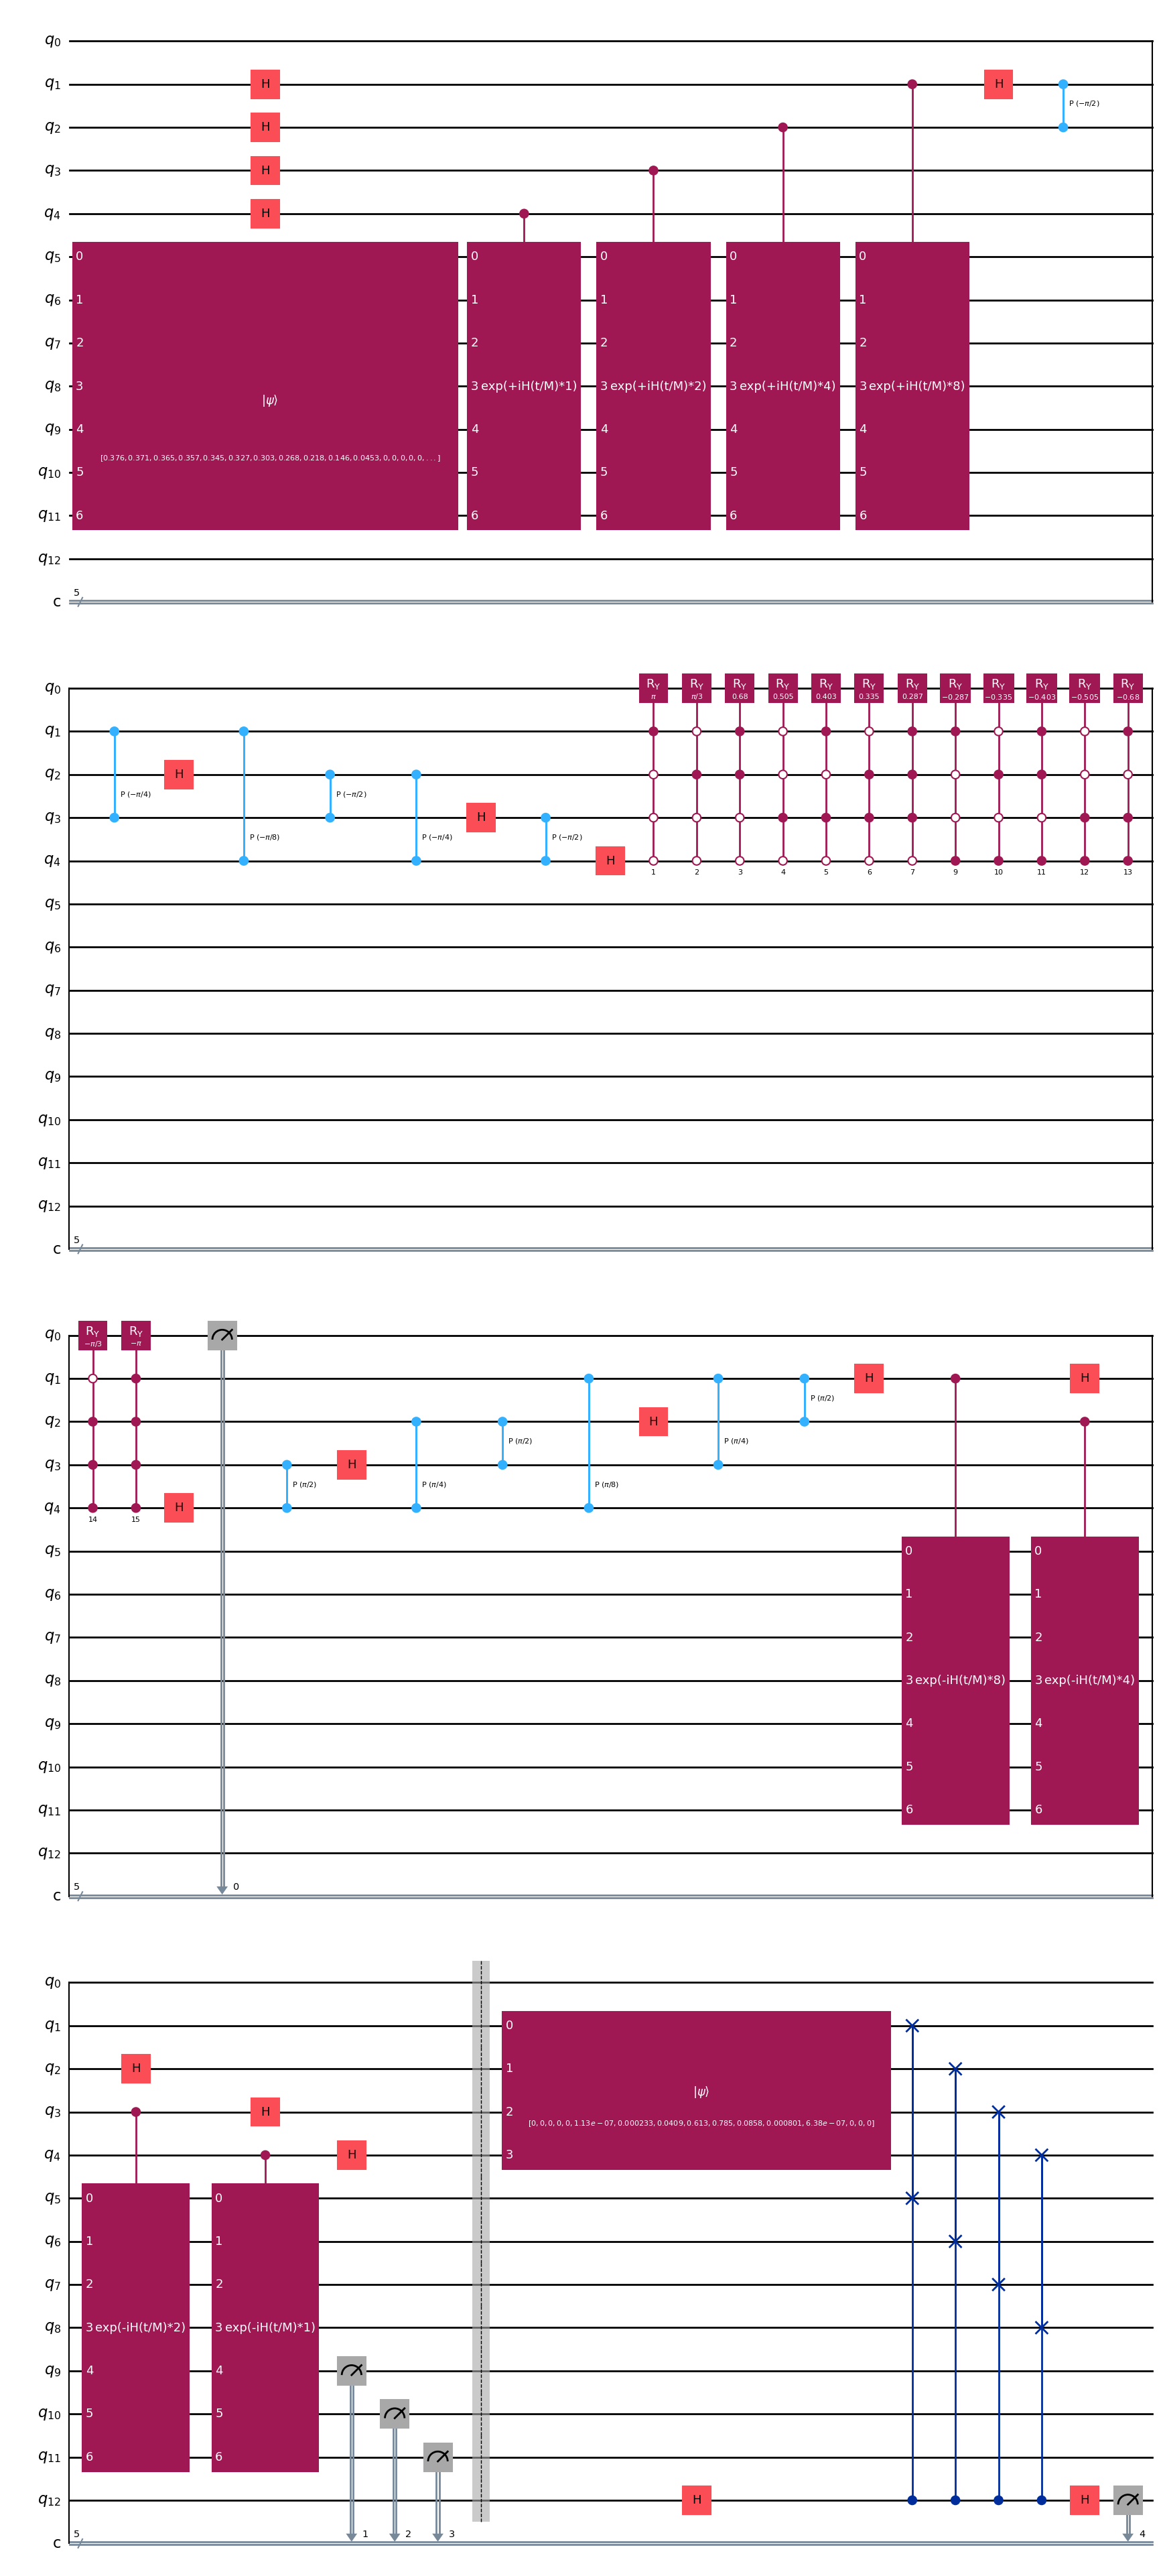

In [9]:
super_circ.draw("mpl")

# Classical solving the matrix system posed to the QLSA & SWAP test algorithm

In [10]:
# HELPER FUNCTIONS 

def overlap_norm(v1,v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def quantum_overlap_norm(p):
    return np.sqrt(1-(2*p))

def norm(v):
    return np.linalg.norm(v)

In [11]:
# Classically solve the EXACT same linear system posed to the quantum computer


z_tilde = np.linalg.solve(herm_M_tilde_scaled,first_vector_scaled)
z_4 = z_tilde[-n_grid:]

print(f"Norm of solution with garbage    : {norm(z_tilde):.3f}")
print(f"Norm of solution without garbage : {norm(z_4):.3f}")
print(f"The ratio of the two norms is    : {norm(z_tilde)/norm(z_4):.3f}")
print("-----------------------------------------")
print("-----------------------------------------")
print("Every term in the classical inner product")
print("-----------------------------------------")
print(f"The normalized overlap between the solution and the second vector is :{overlap_norm(z_4,second_vector):.3f}")
print(f"The norm of the stock price probability vector is                    :{norm(prob_stock_price):.3f}")
print(f"The norm of the solution vector is                                   :{norm(z_4):.3f}")
print("-------------------------------")
classical_overlap_nomrlized =  overlap_norm(z_4,second_vector)
classical_option_value = np.exp(-r*(T_0+T_1))*classical_overlap_nomrlized*norm(prob_stock_price)*norm(z_4)
analytic_value_of_bs = black_scholes_1D_analytic(S_0,K,r,vol,T_0+T_1,'put')
print(f"The clasically calculated normalized overlap between solution and probability vector : {classical_overlap_nomrlized:.3f}")
print(f"The classically calculated option value from the above classical                     : {classical_option_value:.3f}")
print("calculated normalized overlap with norms a priori known ")
print(f"The analytic answer as given by the explicit analytic solution from Black-Scholes    : {analytic_value_of_bs:.3f}")

Norm of solution with garbage    : 199.599
Norm of solution without garbage : 139.243
The ratio of the two norms is    : 1.433
-----------------------------------------
-----------------------------------------
Every term in the classical inner product
-----------------------------------------
The normalized overlap between the solution and the second vector is :0.268
The norm of the stock price probability vector is                    :0.655
The norm of the solution vector is                                   :139.243
-------------------------------
The clasically calculated normalized overlap between solution and probability vector : 0.268
The classically calculated option value from the above classical                     : 23.869
calculated normalized overlap with norms a priori known 
The analytic answer as given by the explicit analytic solution from Black-Scholes    : 23.811


## Circuit transpilation, execution and count management

In [12]:
simulator = AerSimulator(method='automatic')
circuit_transpiled = transpile(super_circ,simulator,optimization_level=1)
backend = Aer.get_backend('aer_simulator')

all_basis_states = [''.join(seq) for seq in itertools.product("01", repeat=5)]
total_running_counts_rel = {state : 0 for state in all_basis_states} # This is the total counts number as we progress through all shot rounds
total_running_counts_abs = {state : 0 for state in all_basis_states} # This is the total counts number as we progress through all shot rounds
average_ancilla_success_rate = []

In [13]:
shots_1 = 150
shots_2 = 150
shots_3 = 150
shots_4 = 150
shots_5 = 150

In [14]:
# ---- Job 1 ---- #


job1 = backend.run(circuit_transpiled,shots=shots_1)
result1 = job1.result()

counts1 = {state: 0 for state in all_basis_states}
counts1.update(result1.get_counts())
ancilla_success_counts1 = {key : counts1[key] for key in sorted(counts1) if key[-1] == '1'}
relevant_counts1 = { key : counts1[key] for key in sorted(counts1) if key[-4:] == '1111' } # Post-selecting for the relevant information
total_running_counts_abs = {key : total_running_counts_abs[key]+counts1[key] for key in sorted(total_running_counts_abs)} # Adding to the total counts
total_running_counts_rel = {key : total_running_counts_rel[key]+counts1[key] for key in sorted(total_running_counts_rel) if key[-4:] == '1111'} # Post-selecting for the relevant information and adding to the total counts

# - Counts for this job - #

counts1_list = list(counts1.values())
prob_counts1_list = counts1_list/np.sum(counts1_list)

relevant_counts1_list = list(relevant_counts1.values())
prob_relevant_counts1_list = relevant_counts1_list/np.sum(relevant_counts1_list)
ancilla_success_counts1 = np.sum(list(ancilla_success_counts1.values()))/shots_1
average_ancilla_success_rate.append(100*ancilla_success_counts1)

print("The relevant counts from just this stage              :",relevant_counts1_list)
print("The probabilities from the counts from just this stage:",prob_relevant_counts1_list)
print("The overlap from this stage                           :",quantum_overlap_norm(prob_relevant_counts1_list[-1]))
print("The ancilla success from just this stage              :%3f percent" %(100*ancilla_success_counts1))

# - Total counts thus far - #
total_running_counts_rel_list = list(total_running_counts_rel.values())
prob_total_running_counts_rel_list = total_running_counts_rel_list/np.sum(total_running_counts_rel_list)


print("The total relevant counts thus far                    :",total_running_counts_rel_list)
print("The probabilities from the total counts thus far      :",prob_total_running_counts_rel_list)
print("The ancilla success probability so far                :%3f percent" %(np.mean(average_ancilla_success_rate)))

The relevant counts from just this stage              : [15, 18]
The probabilities from the counts from just this stage: [0.455 0.545]
The overlap from this stage                           : nan
The ancilla success from just this stage              :44.666667 percent
The total relevant counts thus far                    : [15, 18]
The probabilities from the total counts thus far      : [0.455 0.545]
The ancilla success probability so far                :44.666667 percent


/tmp/ipykernel_2083152/3073267426.py:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-(2*p))


In [15]:
# ---- Job 2 ---- #


job2 = backend.run(circuit_transpiled,shots=shots_2)
result2 = job2.result()

counts2 = {state: 0 for state in all_basis_states}
counts2.update(result2.get_counts())
ancilla_success_counts2 = {key : counts2[key] for key in sorted(counts2) if key[-1] == '1'}
relevant_counts2 = { key : counts2[key] for key in sorted(counts2) if key[-4:] == '1111' } # Post-selecting for the relevant information
total_running_counts_abs = {key : total_running_counts_abs[key]+counts2[key] for key in sorted(total_running_counts_abs)}
total_running_counts_rel = {key : total_running_counts_rel[key]+counts2[key] for key in sorted(total_running_counts_rel) if key[-4:] == '1111'} # Post-selecting for the relevant information and adding to the total counts

# - Counts for this job - #

counts2_list = list(counts2.values())
prob_counts2_list = counts2_list/np.sum(counts2_list)

relevant_counts2_list = list(relevant_counts2.values())
prob_relevant_counts2_list = relevant_counts2_list/np.sum(relevant_counts2_list)
ancilla_success_counts2 = np.sum(list(ancilla_success_counts2.values()))/shots_2
average_ancilla_success_rate.append(100*ancilla_success_counts2)

print("The relevant counts from just this stage              :",relevant_counts2_list)
print("The probabilities from the counts from just this stage:",prob_relevant_counts2_list)
print("The overlap from this stage                           :",quantum_overlap_norm(prob_relevant_counts2_list[-1]))
print("The ancilla success from just this stage              :%3f percent" %(100*ancilla_success_counts2))

# - Total counts thus far - #
total_running_counts_rel_list = list(total_running_counts_rel.values())
prob_total_running_counts_rel_list = total_running_counts_rel_list/np.sum(total_running_counts_rel_list)


print("The total relevant counts thus far                    :",total_running_counts_rel_list)
print("The probabilities from the total counts thus far      :",prob_total_running_counts_rel_list)
print("The ancilla success probability so far                :%3f percent" %(np.mean(average_ancilla_success_rate)))

The relevant counts from just this stage              : [16, 14]
The probabilities from the counts from just this stage: [0.533 0.467]
The overlap from this stage                           : 0.2581988897471611
The ancilla success from just this stage              :43.333333 percent
The total relevant counts thus far                    : [31, 32]
The probabilities from the total counts thus far      : [0.492 0.508]
The ancilla success probability so far                :44.000000 percent


In [16]:
# ---- Job 3 ---- #


job3 = backend.run(circuit_transpiled,shots=shots_3)
result3 = job3.result()

counts3 = {state: 0 for state in all_basis_states}
counts3.update(result3.get_counts())
ancilla_success_counts3 = {key : counts3[key] for key in sorted(counts3) if key[-1] == '1'}
relevant_counts3 = { key : counts3[key] for key in sorted(counts3) if key[-4:] == '1111' } # Post-selecting for the relevant information
total_running_counts_abs = {key : total_running_counts_abs[key]+counts3[key] for key in sorted(total_running_counts_abs)}
total_running_counts_rel = {key : total_running_counts_rel[key]+counts3[key] for key in sorted(total_running_counts_rel) if key[-4:] == '1111'} # Post-selecting for the relevant information and adding to the total counts

# - Counts for this job - #

counts3_list = list(counts3.values())
prob_counts3_list = counts3_list/np.sum(counts3_list)

relevant_counts3_list = list(relevant_counts3.values())
prob_relevant_counts3_list = relevant_counts3_list/np.sum(relevant_counts3_list)
ancilla_success_counts3 = np.sum(list(ancilla_success_counts3.values()))/shots_3
average_ancilla_success_rate.append(100*ancilla_success_counts3)

print("The relevant counts from just this stage              :",relevant_counts3_list)
print("The probabilities from the counts from just this stage:",prob_relevant_counts3_list)
print("The overlap from this stage                           :",quantum_overlap_norm(prob_relevant_counts3_list[-1]))
print("The ancilla success from just this stage              :%3f percent" %(100*ancilla_success_counts3))

# - Total counts thus far - #
total_running_counts_rel_list = list(total_running_counts_rel.values())
prob_total_running_counts_rel_list = total_running_counts_rel_list/np.sum(total_running_counts_rel_list)


print("The total relevant counts thus far                    :",total_running_counts_rel_list)
print("The probabilities from the total counts thus far      :",prob_total_running_counts_rel_list)
print("The ancilla success probability so far                :%3f percent" %(np.mean(average_ancilla_success_rate)))

The relevant counts from just this stage              : [21, 11]
The probabilities from the counts from just this stage: [0.656 0.344]
The overlap from this stage                           : 0.5590169943749475
The ancilla success from just this stage              :42.000000 percent
The total relevant counts thus far                    : [52, 43]
The probabilities from the total counts thus far      : [0.547 0.453]
The ancilla success probability so far                :43.333333 percent


In [17]:
# ---- Job 4 ---- #


job4 = backend.run(circuit_transpiled,shots=shots_4)
result4 = job4.result()

counts4 = {state: 0 for state in all_basis_states}
counts4.update(result4.get_counts())
ancilla_success_counts4 = {key : counts4[key] for key in sorted(counts4) if key[-1] == '1'}
relevant_counts4 = { key : counts4[key] for key in sorted(counts4) if key[-4:] == '1111' } # Post-selecting for the relevant information
total_running_counts_abs = {key : total_running_counts_abs[key]+counts4[key] for key in sorted(total_running_counts_abs)}
total_running_counts_rel = {key : total_running_counts_rel[key]+counts4[key] for key in sorted(total_running_counts_rel) if key[-4:] == '1111'} # Post-selecting for the relevant information and adding to the total counts

# - Counts for this job - #

counts4_list = list(counts4.values())
prob_counts4_list = counts4_list/np.sum(counts4_list)

relevant_counts4_list = list(relevant_counts4.values())
prob_relevant_counts4_list = relevant_counts4_list/np.sum(relevant_counts4_list)
ancilla_success_counts4 = np.sum(list(ancilla_success_counts4.values()))/shots_4
average_ancilla_success_rate.append(100*ancilla_success_counts4)

print("The relevant counts from just this stage              :",relevant_counts4_list)
print("The probabilities from the counts from just this stage:",prob_relevant_counts4_list)
print("The overlap from this stage                           :",quantum_overlap_norm(prob_relevant_counts4_list[-1]))
print("The ancilla success from just this stage              :%3f percent" %(100*ancilla_success_counts4))

# - Total counts thus far - #
total_running_counts_rel_list = list(total_running_counts_rel.values())
prob_total_running_counts_rel_list = total_running_counts_rel_list/np.sum(total_running_counts_rel_list)


print("The total relevant counts thus far                    :",total_running_counts_rel_list)
print("The probabilities from the total counts thus far      :",prob_total_running_counts_rel_list)
print("The ancilla success probability so far                :%3f percent" %(np.mean(average_ancilla_success_rate)))


The relevant counts from just this stage              : [16, 18]
The probabilities from the counts from just this stage: [0.471 0.529]
The overlap from this stage                           : nan
The ancilla success from just this stage              :40.000000 percent
The total relevant counts thus far                    : [68, 61]
The probabilities from the total counts thus far      : [0.527 0.473]
The ancilla success probability so far                :42.500000 percent


/tmp/ipykernel_2083152/3073267426.py:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1-(2*p))


In [18]:
# ---- Job 5 ---- #


job5 = backend.run(circuit_transpiled,shots=shots_5)
result5 = job5.result()

counts5 = {state: 0 for state in all_basis_states}
counts5.update(result5.get_counts())
ancilla_success_counts5 = {key : counts5[key] for key in sorted(counts5) if key[-1] == '1'}
relevant_counts5 = { key : counts5[key] for key in sorted(counts5) if key[-4:] == '1111' } # Post-selecting for the relevant information
total_running_counts_abs = {key : total_running_counts_abs[key]+counts5[key] for key in sorted(total_running_counts_abs)}
total_running_counts_rel = {key : total_running_counts_rel[key]+counts5[key] for key in sorted(total_running_counts_rel) if key[-4:] == '1111'} # Post-selecting for the relevant information and adding to the total counts

# - Counts for this job - #

counts5_list = list(counts5.values())
prob_counts5_list = counts5_list/np.sum(counts5_list)

relevant_counts5_list = list(relevant_counts5.values())
prob_relevant_counts5_list = relevant_counts5_list/np.sum(relevant_counts5_list)
ancilla_success_counts5 = np.sum(list(ancilla_success_counts5.values()))/shots_5
average_ancilla_success_rate.append(100*ancilla_success_counts5)

print("The relevant counts from just this stage              :",relevant_counts5_list)
print("The probabilities from the counts from just this stage:",prob_relevant_counts5_list)
print("The overlap from this stage                           :",quantum_overlap_norm(prob_relevant_counts5_list[-1]))
print("The ancilla success from just this stage              :%3f percent" %(100*ancilla_success_counts5))

# - Total counts thus far - #
total_running_counts_rel_list = list(total_running_counts_rel.values())
prob_total_running_counts_rel_list = total_running_counts_rel_list/np.sum(total_running_counts_rel_list)


print("The total relevant counts thus far                    :",total_running_counts_rel_list)
print("The probabilities from the total counts thus far      :",prob_total_running_counts_rel_list)
print("The ancilla success probability so far                :%3f percent" %(np.mean(average_ancilla_success_rate)))

The relevant counts from just this stage              : [13, 8]
The probabilities from the counts from just this stage: [0.619 0.381]
The overlap from this stage                           : 0.48795003647426666
The ancilla success from just this stage              :38.666667 percent
The total relevant counts thus far                    : [81, 69]
The probabilities from the total counts thus far      : [0.54 0.46]
The ancilla success probability so far                :41.733333 percent


In [19]:
counts = total_running_counts_abs


post_selected_counts = {key: counts[key] for key in sorted(counts) if key[-1] == '1'}    # Post-select 1 for ancilla qubit
post_selected_counts_list = list(post_selected_counts.values())
subspace_post_selected_counts = {key: counts[key] for key in sorted(post_selected_counts) if key[-4:-1] == '111'} # Get access to 8th component of the vector
subspace_post_selected_counts_list = list(subspace_post_selected_counts.values())
complete_post_selection_counts = {key: counts[key] for key in sorted(post_selected_counts) if key[-4:] == '1111'} # Do hhl and norm estimation together rather than separately


# subspace_post_selected_counts = total_running_counts_rel
subspace_post_selected_counts_list = list(subspace_post_selected_counts.values())
subspace_post_selected_prob = subspace_post_selected_counts_list/np.sum(subspace_post_selected_counts_list)  # Post-select 111 for second vector qubits
# Post-select 11 for ancilla qubits
counts_lists = list(counts.values())
print("            --- Counts ---            ")
print(counts)
print(np.sum(list(counts.values())))
print("\n")
print("  --- HHL Post-selection counts ---   ")
print(post_selected_counts)
print(np.sum(list(post_selected_counts.values())))
print("\n")
print("--- Subspace Post-selection counts ---")
print(subspace_post_selected_counts)
print("\n")
print(subspace_post_selected_counts_list)
print(subspace_post_selected_prob)
print("\n")

prob_list = [post_selected_counts[key]/np.sum(list(post_selected_counts.values())) for key in sorted(post_selected_counts)]
ancilla_prob_postselected = np.sum(post_selected_counts_list)/np.sum(counts_lists)

quantum_overlap = quantum_overlap_norm(subspace_post_selected_prob[-1]) # Number of times 1 appears in SWAP test 
classical_expected_quantum_overlap = overlap_norm(second_vector,z_4) # What we should see if we were to do this classically


measured_norm_z_tilde = (norm(first_vector_scaled)/C)*np.sqrt(ancilla_prob_postselected)   # We need to know norm of input vector in advance
measured_norm_z_4 =  (norm(first_vector_scaled)/C)*np.sqrt((np.sum(list(complete_post_selection_counts.values())))/(np.sum(list(counts.values()))))

actual_norm_p = norm(prob_stock_price)
# Just take number of counts in the 1111 state and divide by total number of counts, thats all im doing above



print("---")
print("+---------------------------------------------------------+")
print("--- Normalized overlap between two states ---")
print("+---------------------------------------------------------+")
print(f"Measured quantum overlap with norm1 vectors : \033[33m{quantum_overlap:.3f}\033[0m")
print(f"Actual quantum overlap with norm1 vectors   : \033[32m{classical_expected_quantum_overlap:.3f}\033[0m")   
print(f"Measured ancilla post-selection probability : \033[33m{100*ancilla_prob_postselected:.3f}\033[0m %")
print(f"Actual ancilla post-selection probability   : \033[32m{((C**2)/(norm(first_vector_scaled)**2))*(norm(z_tilde)**2)*100:.3f}\033[0m %")
print("+----------------------------------------------------------+")
print("--- Norm of z_tilde and z_4 ---")
print("+----------------------------------------------------------+")
print(f"Measured norm of  z_tilde             : \033[33m{measured_norm_z_tilde:.3f}\033[0m")
print(f"Actual norm of    z_tilde             : \033[32m{norm(z_tilde):.3f}\033[0m")
print(f"Measured norm of  z_4                 : \033[33m{measured_norm_z_4:.3f}\033[0m")
print(f"Actual norm of    z_4                 : \033[32m{norm(z_4):.3f}\033[0m")
print("+----------------------------------------------------------+")
print("--- Norm of probability vec P ---")
print("+----------------------------------------------------------+")
print(f"Actual norm of    vec P               : {actual_norm_p:.3f}")
print("+----------------------------------------------------------+")
print("--- Un-normalized overlap between two states ---")
print("+----------------------------------------------------------+")
print(f"Measured non-normalized inner product  : \033[37m{quantum_overlap*measured_norm_z_tilde*actual_norm_p:.3f}\033[0m")  # For a prob_distribution for second vector, norm will be 1
print(f"Actual inner product by actual norm    : \033[37m{classical_expected_quantum_overlap*norm(z_4)*actual_norm_p:.3f}\033[0m")

            --- Counts ---            
{'00000': 155, '00001': 4, '00010': 15, '00011': 2, '00100': 25, '00101': 0, '00110': 29, '00111': 0, '01000': 1, '01001': 90, '01010': 0, '01011': 2, '01100': 0, '01101': 0, '01110': 1, '01111': 81, '10000': 160, '10001': 3, '10010': 15, '10011': 0, '10100': 18, '10101': 0, '10110': 17, '10111': 0, '11000': 1, '11001': 61, '11010': 0, '11011': 0, '11100': 0, '11101': 1, '11110': 0, '11111': 69}
750


  --- HHL Post-selection counts ---   
{'00001': 4, '00011': 2, '00101': 0, '00111': 0, '01001': 90, '01011': 2, '01101': 0, '01111': 81, '10001': 3, '10011': 0, '10101': 0, '10111': 0, '11001': 61, '11011': 0, '11101': 1, '11111': 69}
313


--- Subspace Post-selection counts ---
{'01111': 81, '11111': 69}


[81, 69]
[0.54 0.46]


---
+---------------------------------------------------------+
--- Normalized overlap between two states ---
+---------------------------------------------------------+
Measured quantum overlap with norm1 vectors : 0.283
A

In [20]:
opt_class=black_scholes_1D_analytic(S_0,K,r,vol,T_0+T_1,'put')
option_quantum_priced=np.exp(-r*(T_0 + T_1))*quantum_overlap*measured_norm_z_4*norm(prob_stock_price)
opt_quant_scaled_by_class_norm = np.exp(-r*(T_0 + T_1))*quantum_overlap*norm(z_4)*norm(prob_stock_price)

print(f"Classically calculated option value      : {opt_class:.3f}")
print(f"Quantumly  calculated option value       : {option_quantum_priced:.3f}")
print(f"Quantumly  calculated opt value assisted : {opt_quant_scaled_by_class_norm:.3f}")
print("----")
print(f"Error                                    : {np.abs(opt_class-option_quantum_priced)/(opt_class)*100:.3f} %")

Classically calculated option value      : 23.811
Quantumly  calculated option value       : 25.173
Quantumly  calculated opt value assisted : 25.175
----
Error                                    : 5.723 %
